# Estimación de parámetros de curvas: estimación de fallecidos basados en los datos existentes

Vamos a utilizar la libreria `scipy` para estimar parámetros de la curva para que minimice las diferencias con los datos reales. Nos sirve esta curva para estimar datos futuros?: mi opinión es que no tiene por qué, la evolución de estos sistemas a priori no ha de seguir este patrón. Esto es una simple aproximación con métodos matemáticos, en los que no hay ninguna influencia de, por ejemplo, las fases de desconfinamiento que se están aplicando estos días.

Empecemos como siempre preparando el entorno importando las librerías que vamos a necesitar:

In [148]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib import cm
import numpy as np
from datetime import datetime,timedelta
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.special import erf

VAriable con el path del fichero en el que encontramos los datos, son actualizados diariamente:

In [149]:
path='https://covid19.isciii.es/resources/serie_historica_acumulados.csv'

Descargamos los datos y los guardamos en un `pandas`

In [150]:
df = pd.read_csv(path,encoding='ISO-8859-1',engine='python',skipfooter=9)

Veamos el formato de los datos:

In [151]:
df.columns

Index(['CCAA', 'FECHA', 'CASOS', 'PCR+', 'TestAc+', 'Hospitalizados', 'UCI',
       'Fallecidos'],
      dtype='object')

In [152]:
df.head()

,CCAA,FECHA,CASOS,PCR+,TestAc+,Hospitalizados,UCI,Fallecidos
0,AN,20/2/2020,0.0,0,NaN,NaN,NaN,NaN
1,AR,20/2/2020,NaN,0,NaN,NaN,NaN,NaN
2,AS,20/2/2020,NaN,0,NaN,NaN,NaN,NaN
3,IB,20/2/2020,NaN,1,NaN,NaN,NaN,NaN
4,CN,20/2/2020,NaN,1,NaN,NaN,NaN,NaN


In [153]:
df.tail()

,CCAA,FECHA,CASOS,PCR+,TestAc+,Hospitalizados,UCI,Fallecidos
1724,ML,20/5/2020,NaN,121,13.0,44.0,3.0,2.0
1725,MC,20/5/2020,NaN,1570,1039.0,680.0,112.0,149.0
1726,NC,20/5/2020,NaN,5195,3157.0,2048.0,136.0,506.0
1727,PV,20/5/2020,NaN,13421,5358.0,7032.0,578.0,1483.0
1728,RI,20/5/2020,NaN,4033,1395.0,1504.0,91.0,354.0


Vamos a crear un `dictionary` que tenga como clave (`index`
) las iniciales del nombre de la Comunidad Autónoma usado en los datos, añadiéndole, además, la población:

In [154]:
comunidades={'AN':['Andalucia',8426405],
 'AR':['Aragon',1320794],
 'AS':['Asturias',1022293],
 'CB':['Cantabria',581684],
 'CE':['Ceuta',84843],
 'CL':['Castilla y León',2408083],
 'CM':['Castilla La Mancha',2035505],
 'CN':['Islas Canarias',2207225],
 'CT':['Cataluña',7565099],
 'EX':['Extremadura',1065371],
 'GA':['Galicia',2700330],
 'IB':['Islas Baleares',1187802],
 'MC':['Murcia',1487698],
 'MD':['Madrid',6640705],
 'ML':['Melilla',84714],
 'NC':['Navarra',649966],
 'PV':['Pais Vasco',2178048],
 'RI':['Rioja',313582],
 'VC':['Valencia',4974475]}

In [155]:
df=df.fillna(0)

In [156]:
pob_spain=0
for com in comunidades:
    pob_spain+=comunidades[com][1]

In [157]:
df['Fallecidos'].sum()

1146116.0

In [158]:
comunidades.keys()

dict_keys(['AN', 'AR', 'AS', 'CB', 'CE', 'CL', 'CM', 'CN', 'CT', 'EX', 'GA', 'IB', 'MC', 'MD', 'ML', 'NC', 'PV', 'RI', 'VC'])

In [159]:
df['FECHA']=pd.to_datetime(df['FECHA'],format='%d/%m/%Y')
df.sort_values(['FECHA'],inplace=True)

In [160]:
df.set_index(['FECHA','CCAA'],inplace=True)

In [161]:
df.fillna(0)

CASOS   PCR+  TestAc+  Hospitalizados     UCI  Fallecidos
FECHA      CCAA                                                           
2020-02-20 AN      0.0      0      0.0             0.0     0.0         0.0
           RI      0.0      0      0.0             0.0     0.0         0.0
           PV      0.0      0      0.0             0.0     0.0         0.0
           NC      0.0      0      0.0             0.0     0.0         0.0
           MC      0.0      0      0.0             0.0     0.0         0.0
...                ...    ...      ...             ...     ...         ...
2020-05-20 AR      0.0   5588   1751.0          2442.0   256.0       848.0
           AN      0.0  12547   3999.0          6210.0   766.0      1375.0
           PV      0.0  13421   5358.0          7032.0   578.0      1483.0
           CT      0.0  55888   1643.0         29497.0  2969.0      6021.0
           RI      0.0   4033   1395.0          1504.0    91.0       354.0

[1729 rows x 6 columns]

In [162]:
resumen=df.pivot_table(index=['FECHA'],values=['CASOS','Hospitalizados','Fallecidos'],aggfunc=np.sum)

In [163]:
resumen['Fallecidos_diarios']=resumen['Fallecidos'].diff().fillna(0)

In [164]:
#resumen=resumen.drop(resumen.index[-1])

In [165]:
#resumen['Fallecidos_diarios'].iloc[-1]

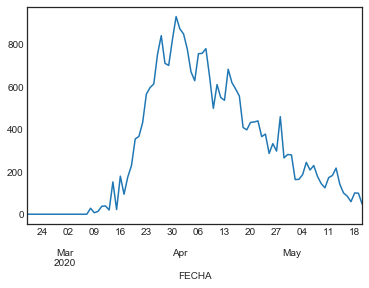

In [166]:
resumen['Fallecidos_diarios'].plot()

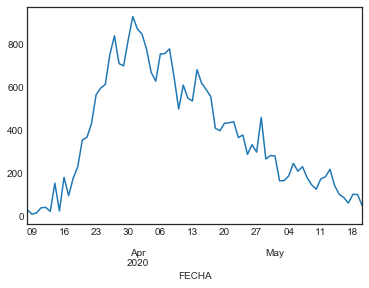

In [74]:
resumen[resumen['Fallecidos_diarios']>0]['Fallecidos_diarios'].plot()

In [75]:
dia_zero=resumen[resumen['Fallecidos_diarios']>0].index[0]

In [76]:
dia_zero

Timestamp('2020-03-08 00:00:00')

In [77]:
y=resumen[resumen['Fallecidos_diarios']>0]['Fallecidos_diarios'].to_numpy()

In [78]:
x=np.arange(y.size)

In [79]:
def func(x, sigma, mu, alpha,a):
    c = 0
    #normal distribution
    normpdf = (1/(sigma*np.sqrt(2*np.pi)))*np.exp(-(np.power((x-mu),2)/(2*np.power(sigma,2))))
    normcdf = (0.5*(1+erf((alpha*((x-mu)/sigma))/(np.sqrt(2)))))
    return 2*a*normpdf*normcdf + c

In [80]:
def func_2(x, sigma, mu, alpha,a):
    c = 0
    #normal distribution
    normpdf = (1/(sigma*np.sqrt(2*np.pi)))*np.exp(-(np.power((x-mu),2)/(2*np.power(sigma,2))))
    normcdf = (0.5*(1+erf((alpha*((x-mu)/sigma))/(np.sqrt(2)))))
    return 2*a*normpdf*normcdf + c

In [81]:
popt, pcov = curve_fit(func, x, y, p0=(1,1,1,20000))
print(popt)
print(pcov)

[2.61144244e+01 1.35024699e+01 5.65776482e+00 2.82933209e+04]
[[ 5.29581734e-01 -1.35067207e-01  2.54697474e-01  2.15978756e+02]
 [-1.35067207e-01  1.00573740e-01 -7.47443097e-02 -5.19831585e+01]
 [ 2.54697474e-01 -7.47443097e-02  4.04098668e-01  2.12536218e+01]
 [ 2.15978756e+02 -5.19831585e+01  2.12536218e+01  2.99852765e+05]]


In [82]:
func(y.size, *popt)

59.0691199425756

In [83]:
xFit = np.arange(0.0, 100, 1)
datelist_forecast = pd.date_range(dia_zero, periods=100).tolist()
datelist_actual=pd.date_range(dia_zero, periods=x.size)

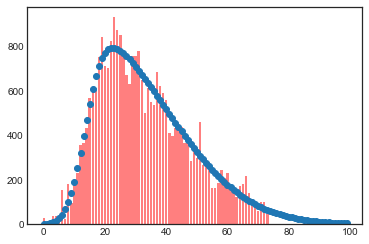

In [84]:
plt.style.use('seaborn-white')
plt.bar(x, y, align='center', color='red',alpha=.5)
plt.plot(xFit, func(xFit, *popt), 'o')
plt.show()

In [85]:
def format_major_x(value, tick_number):
    #return  tick_number
    return datetime.fromordinal(int(value)).strftime('%d-%b')
def format_minor_x(value, tick_number):
    return  value
def format_y(value, tick_number):
    return '{:.1f}'.format(value)

In [86]:
posicion_y=np.arange(0,max(y),50).tolist()
posicion_x=datelist_forecast[::4]

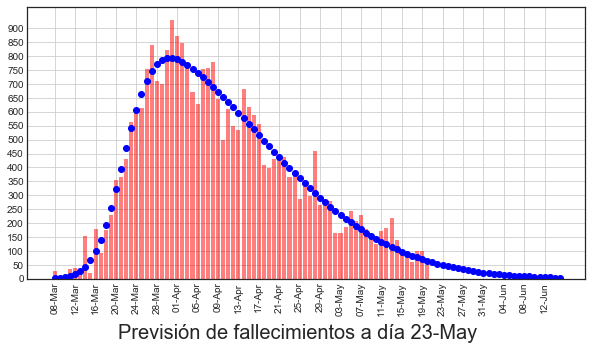

In [87]:
f = plt.figure(figsize=(10,5))
titulo='Previsión de fallecimientos a día '+datetime.today().strftime('%d-%b')
f.suptitle(titulo,fontsize=20,x=0.5,y=0)
ax = f.add_subplot(1,1,1)
ax.bar(datelist_actual,y, alpha=.5,color='red')
ax.set_yticks(posicion_y,'major')
ax.xaxis_date()
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_major_x))
ax.plot(datelist_forecast,func(xFit, *popt),'bo')
ax.set_yticks(posicion_y)
ax.set_xticks(posicion_x)
#ax.set_ylim([0,400])
ax.xaxis.set_tick_params(rotation=90)
ax.grid(True)
path_save='graficos/forecast_'+datetime.today().strftime('%d-%b')+'.png'
f.savefig(path_save)
plt.show()

In [88]:
posicion_y=np.arange(0,max(y),20).tolist()
posicion_x=datelist_forecast[::]
fecha_inicio=datetime.today()-timedelta(days=10)
fecha_fin=fecha_inicio+timedelta(days=50)
limite_fechas=[fecha_inicio,fecha_fin]
rango_fechas=np.arange(fecha_inicio+timedelta(days=1),fecha_fin+timedelta(days=1), dtype='datetime64[D]')
style_etiquetas = dict(size=9, color='blue',rotation='vertical',horizontalalignment='left')

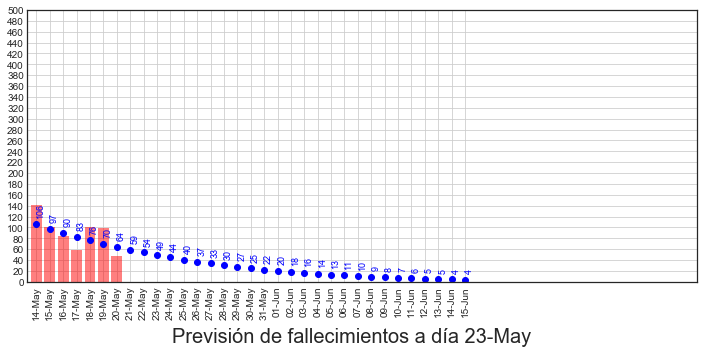

In [89]:
#sns.set_style("whitegrid")
#sns.set_palette(sns.color_palette("RdBu_r",19))
f = plt.figure(figsize=(12,5))
#f.subplots_adjust(hspace=.5, wspace=.5)
titulo='Previsión de fallecimientos a día '+datetime.today().strftime('%d-%b')
f.suptitle(titulo,fontsize=20,x=0.5,y=0)

ax = f.add_subplot(1,1,1)
#ax2=ax.twinx()
#ax2.grid(False)
#colors = cm.RdYlBu_r(rango_color)
ax.bar(datelist_actual,y, alpha=.5,color='red')
ax.set_yticks(posicion_y,'major')
ax.xaxis_date()
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_major_x))
ax.plot(datelist_forecast,func(xFit, *popt),'bo')
ax.set_yticks(posicion_y)
ax.set_xticks(posicion_x)
ax.set_xlim(limite_fechas)
ax.set_ylim([0,500])
ax.xaxis.set_tick_params(rotation=90)
ax.grid(True)

for i,j in enumerate(datelist_forecast):
    if j in rango_fechas:
     ax.text(j,func(i,*popt)+15, int(func(i,*popt)), **style_etiquetas)

path_save='graficos/forecast_zoom_'+datetime.today().strftime('%d-%b')+'.png'
plt.show()